<a href="https://colab.research.google.com/github/PratyushJha254/Feature-Based-Dynamic-Pricing-Paper-Implementation-Cohen-et-al.-2020-/blob/main/EllipsoidPricing_ShallowPricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EllipsoidPricing

In [ ]:
#Importing the important libraries
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import math

In [ ]:
#Random Number Seed
seed = 2+0+4+1+0+0+2+2
np.random.seed(seed)
R = 1

In [ ]:
#Function for EllipsoidPricing Algorithm
@jit(nopython=True)
def EllipsoidPricing(ep, theta, d, T):
    '''
      Function for calculating prices using the EllipsoidPricing algorithm.
    '''
    num_explore = np.zeros(T)  #Array for checking whether ith timestamp is explore step or exploit step
    at = np.zeros(d, dtype=np.float64) #Center of the Ellipsoid
    At = np.eye(d, dtype=np.float64) #Positive definite matrix A
    rew = 0   #Reward
    regret = np.zeros(T) #Array to store the regret
    for i in range(T):
        #xt is the normalized feature vector(context) sampled from normal distribution
        xt = np.random.normal(0, 1, d)
        xt = xt / np.sqrt(np.sum(xt ** 2))
        xt = np.abs(xt)

        #Actual market value of the product
        v = theta.T @ xt

        #Calculation of minimum and maximum possible price within the unceratinty region
        dell = np.sqrt(xt.T @ At @ xt)
        bt_min = xt.T @ at - dell  #Minimum possible price
        bt_max = xt.T @ at + dell  #Maximum possible price

        #Performing binary search
        delta = 2 * dell  #Difference between bt_max and bt_min
        pt = 0  #Predicted price of the product
        if delta <= ep:  #If delta<epsilon, then choose set price to be the minimum possible price.
            pt = bt_min
            rew += pt #Lowest price guarantees reward
        else:
            num_explore[i] = 1  #Current timestamp is for exploration
            #Initiallizing all the important vectors for calculating A(t+1)
            b = (At @ xt) / dell
            pt = (bt_min + bt_max) / 2 #Price must be average of minimum and maximum price
            bb = (b[:, np.newaxis] @ b[np.newaxis, :])
            At = ((d ** 2) / (d ** 2 - 1)) * (At - (2 / (d + 1)) * bb) #Updating At
            #Comparing the set price with actual price and collecting the corresponding reward
            if pt <= v:
                rew += pt
                at = at + b / (d + 1) #Updating the center
            else:
                rew += 0
                at = at - b / (d + 1) #Updating the center

        reg = v - (pt * (pt <= v)) #Updating the regret

        #Updating cumulative regret
        if i == 0:
            regret[i] = reg
        else:
            regret[i] = regret[i - 1] + reg

    return regret, num_explore


In [ ]:
#Function for calculating the EllipsoidPricing algorithm's expected regret
@jit(nopython = True)
def ExpectedValue_EllipsoidPricing(ep, theta, d, T, epochs):
  regret = np.zeros(T)
  explore = np.zeros(T)
  #Running EllipsoidPricing for epochs number of episodes
  for i in range(epochs):
    regret_temp, explore_temp = EllipsoidPricing(ep, theta, d, T)
    regret += regret_temp
    explore +=explore_temp

  regret = regret/epochs
  explore = explore/epochs
  return regret, explore

In [ ]:
# @jit(nopython = True)
def plott(regret, T, minD = 0, maxD = 0, fst = True):
  if(fst):
    plt.plot(np.log(np.linspace(1,T,T)), regret)
  else:
    plt.plot(np.linspace(minD,maxD-1, maxD-minD), regret)
  plt.legend()

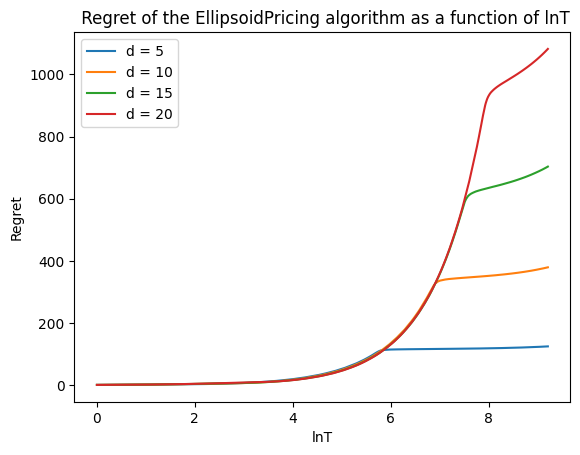

In [ ]:
# graph_1
dimensions = [5,10,15,20]
for d in dimensions:
  T=10000
  ep = R*(d**2)/T
  theta = np.random.normal(0,1,d)
  theta = theta/np.sqrt(np.sum(theta**2))
  theta = np.abs(theta)
  epochs = 100
  regret, _ = ExpectedValue_EllipsoidPricing(ep, theta, d, T, epochs)
  plt.plot(np.log(np.linspace(1,T,T)), regret, label = "d = " + str(d))
plt.xlabel("lnT")
plt.ylabel("Regret")
plt.title(" Regret of the EllipsoidPricing algorithm as a function of lnT")
plt.legend()


In [ ]:
d = 15
T=10000
ep = R*(d**2)/T
theta = np.random.normal(0,1,d)
theta = theta/np.sqrt(np.sum(theta**2))
theta = np.abs(theta)
epochs = 100
gap = 500
_, explore = ExpectedValue_EllipsoidPricing(ep, theta, d, T, epochs)

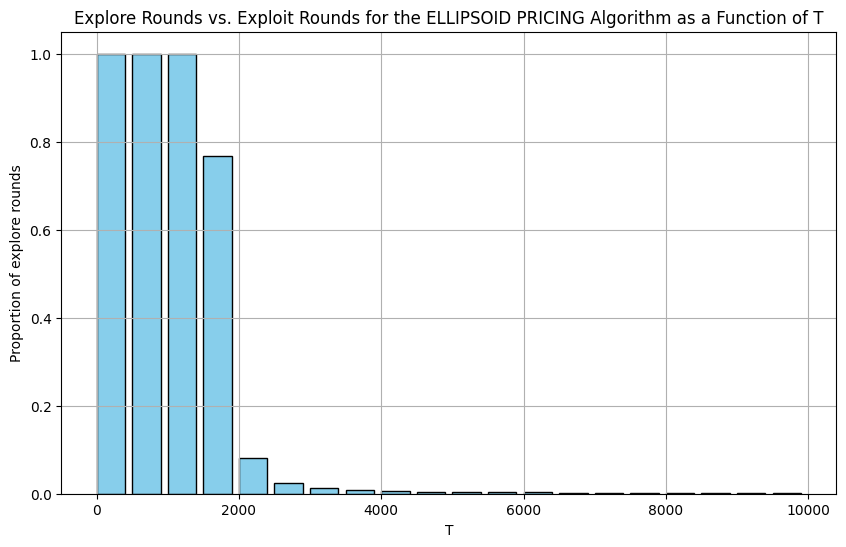

In [ ]:
import matplotlib.pyplot as plt

data = explore  # Generating random binary data

# Calculate counts of 1s in intervals of 500
counts = []
for i in range(0, T, 500):
    counts.append(np.sum(data[i:i+500]))

counts = np.array(counts)/500
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(0, T, 500), counts, width=400, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('T')
plt.ylabel('Proportion of explore rounds')
plt.title('Explore Rounds vs. Exploit Rounds for the ELLIPSOID PRICING Algorithm as a Function of T')
plt.grid(True)
plt.show()

In [ ]:
@jit(nopython=True)
def graph_2(minD, maxD, T, epochs):
  regret_2 = np.zeros(maxD-minD)
  for d in range(minD,maxD):
    ep = R*(d**2)/T
    theta = np.random.normal(0,1,d)
    theta = theta/np.sqrt(np.sum(theta**2))
    theta = np.abs(theta)
    regret, _ = ExpectedValue_EllipsoidPricing(ep, theta, d, T, epochs)
    regret_2[d-minD] = regret[T-1]
  return regret_2

In [ ]:
T=10000
epochs = 100
minD = 5
maxD = 30
regret_dim = graph_2(minD, maxD, T, epochs)

Text(0.5, 1.0, ' Regret of the EllipsoidPricing algorithm as a function of d for T = 10000')

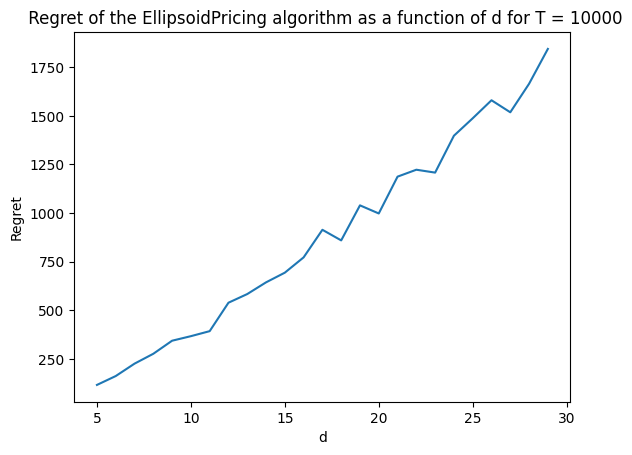

In [ ]:
# plott(regret_dim, T, minD=minD, maxD=maxD, fst=False)
plt.plot(np.linspace(minD,maxD-1, maxD-minD), regret_dim)
plt.ylabel("Regret")
plt.xlabel("d")
plt.title(" Regret of the EllipsoidPricing algorithm as a function of d for T = 10000")

## Adaptability

In [ ]:
@jit(nopython=True)
def EllipsoidPricing_adaptability1(ep, theta, d, T, part = 1):
    '''
      EllipsoidPricing algorithm is tested for its adaptability towards:
      (i) Introduction of features from different distribution midway.
      (ii) Introduction of zero-valued features attaining non zero values only after T/2
    '''

    num_explore = np.zeros(T)
    at = np.zeros(d, dtype=np.float64)
    At = np.eye(d, dtype=np.float64)
    rev = 0
    regret = np.zeros(T)
    for i in range(T):
        xt = np.random.normal(0, 1, d)
        if(part == 1):
          #Till T/2 features are sampled from one particular distribution, after which they are sampled from another distribution
            if(i <= T/2):
                xt = np.random.normal(0, 1, d)
                # xt = np.random.uniform(-0.5, 0.5, d)
                # xt = np.ones(d)
            else:
                xt = np.random.uniform(-0.5, 0.5, d)
                # xt = np.random.normal(0, 1, d)
        else:
          #Till T/2 half of the features are kept to be hidden(zero)
            if(i<=T/2):
                for _ in range(math.ceil(d/2), d):
                    xt[_] = 0
        xt = xt / np.sqrt(np.sum(xt ** 2))
        xt = np.abs(xt)
        dell = np.sqrt(xt.T @ At @ xt)
        bt_min = xt.T @ at - dell
        bt_max = xt.T @ at + dell
        delta = 2 * dell
        v = theta.T @ xt
        pt = 0
        if delta <= ep:
            pt = bt_min
            rev += pt
        else:
            num_explore[i] = 1
            b = (At @ xt) / dell
            pt = (bt_min + bt_max) / 2
            bb = (b[:, np.newaxis] @ b[np.newaxis, :])
            At = ((d ** 2) / (d ** 2 - 1)) * (At - (2 / (d + 1)) * bb)
            if pt <= v:
                rev += pt
                at = at + b / (d + 1)
            else:
                rev += 0
                at = at - b / (d + 1)

        reg = v - (pt * (pt <= v))

        if i == 0:
            regret[i] = reg
        else:
            regret[i] = regret[i - 1] + reg

    return regret, num_explore


In [ ]:
#Function for calculating the expected regret
@jit(nopython = True)
def ExpectedValue_EllipsoidPricing_adaptability1(ep, theta, d, T, epochs, part = 1):
  regret = np.zeros(T)
  explore = np.zeros(T)
  for i in range(epochs):
    regret_temp, explore_temp = EllipsoidPricing_adaptability1(ep, theta, d, T, part = part)
    regret += regret_temp
    explore += explore_temp

  regret = regret/epochs
  explore = explore/epochs
  return regret, explore

In [ ]:
# @jit(nopython = True)
def plott_adaptability(regret, T, minD = 0, maxD = 0, fst = True):
  if(fst):
    plt.plot((np.linspace(1,T,T)), regret)
  else:
    plt.plot(np.linspace(minD,maxD-1, maxD-minD), regret)

In [ ]:
# graph_3
d = 25
T=10000
ep = R*(d**2)/T
theta = np.random.normal(0,1,d)
theta = theta/np.sqrt(np.sum(theta**2))
theta = np.abs(theta)
epochs = 100
regret, explore = ExpectedValue_EllipsoidPricing_adaptability1(ep, theta, d, T, epochs)

Text(0.5, 1.0, 'Normal then uniform features')

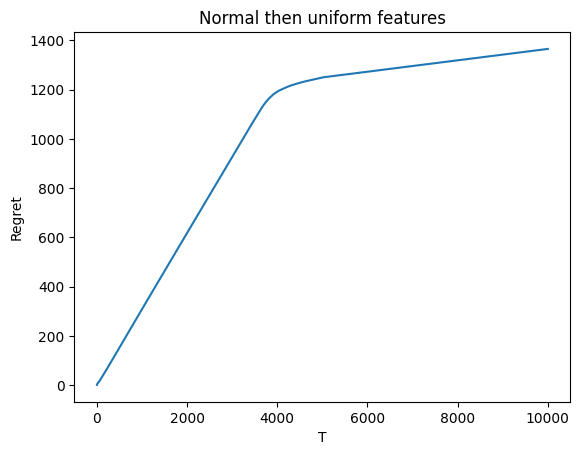

In [ ]:
plt.plot((np.linspace(1,T,T)), regret)
plt.xlabel("T")
plt.ylabel("Regret")
plt.title("Normal then uniform features")

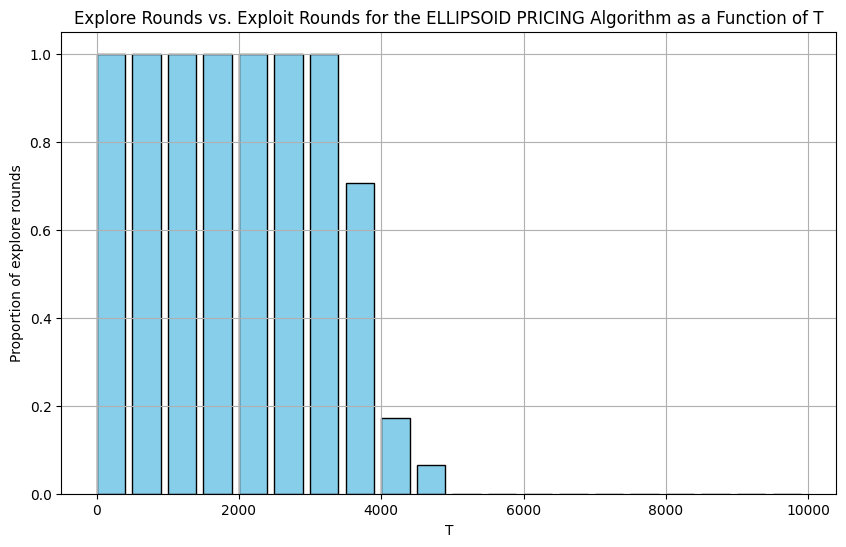

In [ ]:
data = explore  # Generating random binary data

# Calculate counts of 1s in intervals of 500
counts = []
for i in range(0, T, 500):
    counts.append(np.sum(data[i:i+500]))

counts = np.array(counts)/500
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(0, T, 500), counts, width=400, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('T')
plt.ylabel('Proportion of explore rounds')
plt.title('Explore Rounds vs. Exploit Rounds for the ELLIPSOID PRICING Algorithm as a Function of T')
plt.grid(True)
plt.show()

In [ ]:
# graph_4
d = 15
T=10000
ep = R*(d**2)/T
theta = np.random.normal(0,1,d)
theta = theta/np.sqrt(np.sum(theta**2))
theta = np.abs(theta)
epochs = 100
regret, explore = ExpectedValue_EllipsoidPricing_adaptability1(ep, theta, d, T, epochs, part = 2)

Text(0.5, 1.0, ' Half then all features')

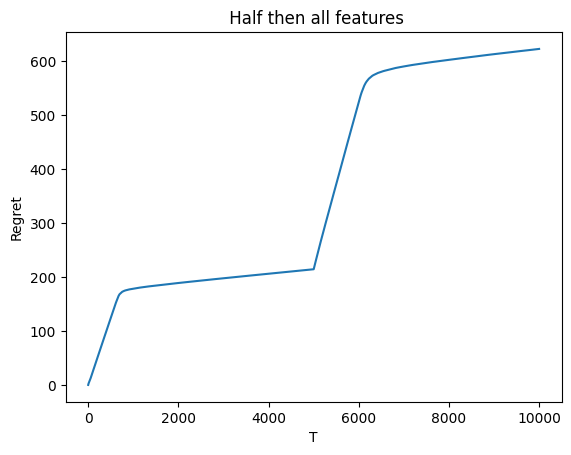

In [ ]:
plt.plot((np.linspace(1,T,T)), regret)
plt.xlabel("T")
plt.ylabel("Regret")
plt.title(" Half then all features")

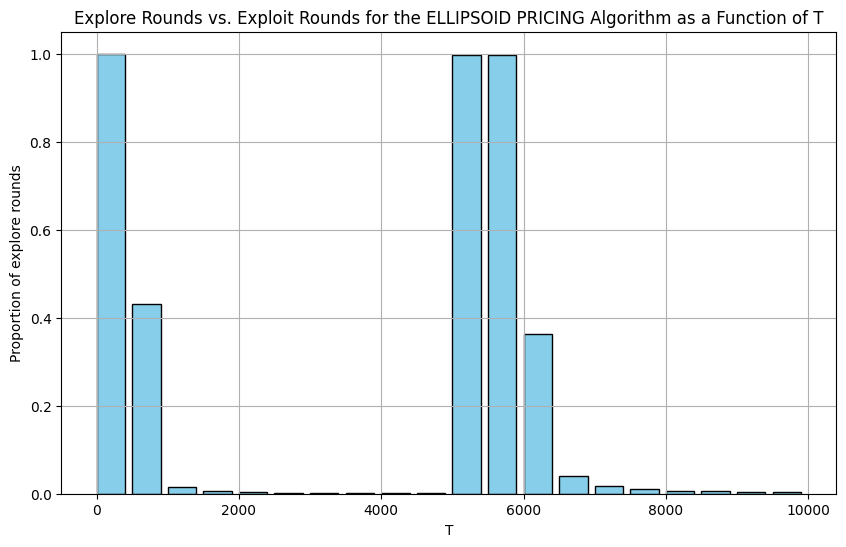

In [ ]:
data = explore  # Generating random binary data

# Calculate counts of 1s in intervals of 500
counts = []
for i in range(0, T, 500):
    counts.append(np.sum(data[i:i+500]))

counts = np.array(counts)/500
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(0, T, 500), counts, width=400, align='edge', color='skyblue', edgecolor='black')
plt.xlabel('T')
plt.ylabel('Proportion of explore rounds')
plt.title('Explore Rounds vs. Exploit Rounds for the ELLIPSOID PRICING Algorithm as a Function of T')
plt.grid(True)
plt.show()

## Comparing Our Algorithm to a Benchmark from the Literature (EXP4)

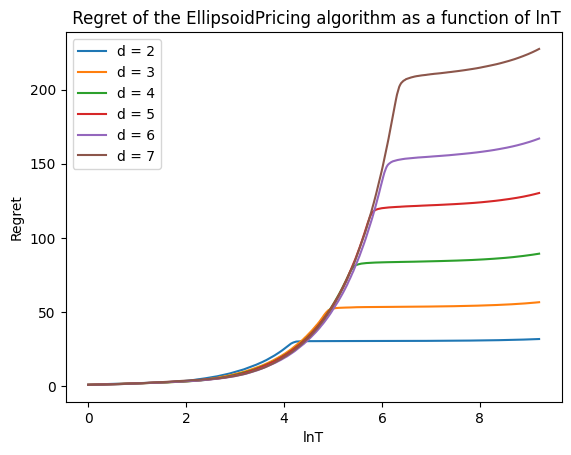

In [ ]:
# graph_1
dimensions = [2,3,4,5,6,7]
for d in dimensions:
  T=10000
  ep = R*(d**2)/T
  theta = np.random.normal(0,1,d)
  theta = theta/np.sqrt(np.sum(theta**2))
  theta = np.abs(theta)
  epochs = 100
  regret, _ = ExpectedValue_EllipsoidPricing(ep, theta, d, T, epochs)
  plt.plot(np.log(np.linspace(1,T,T)), regret, label = "d = " + str(d))
plt.xlabel("lnT")
plt.ylabel("Regret")
plt.title(" Regret of the EllipsoidPricing algorithm as a function of lnT")
plt.legend()


# SHALLOW PRICING

In [ ]:
@jit(nopython=True)
def ShallowPricing(theta, d, T):
    '''
      Function for calculating prices through ShallowPricing algorithm
    '''
    #Initiallizing all the arrays similar to EllipsoidPricing
    num_explore = np.zeros(T)
    at = np.zeros(d, dtype=np.float64)
    At = np.eye(d, dtype=np.float64)
    regret = np.zeros(T)
    rew = 0
    #Incorporating noise through parameter sigma
    sigma = 0.1
    DELTA = np.sqrt(2)*sigma*np.log(T)

    for i in range(T):
        DELTA_t = np.random.normal(0,sigma) #Noise at each time sampled from normal distribution

        #Market value of the product
        v = theta.T @ xt + DELTA_t

        #Obtaining the normalized feature vector from uniform distribution
        xt = np.random.normal(0, 1, d)
        xt = xt / np.sqrt(np.sum(xt ** 2))
        xt = np.abs(xt)

        #Calculating overall maximum and minimum possible price
        dell = np.sqrt(xt.T @ At @ xt)
        bt_min = xt.T @ at - dell
        bt_max = xt.T @ at + dell
        delta = 2 * dell #Difference between maximum and minimum price

        #Updating the depth of cut
        ALPHA_t = max(-DELTA/dell, -1/d)

        #Performing binary search
        pt = 0 #Predicted price of the product

        #If delta<=epsilon: exploit and set the lowest possible price adjusted according to ShallowPricing
        if delta <= ep:
            pt = bt_min - DELTA
            rew += pt
        else:
            num_explore[i] = 1 #ith step is now explore step

            #Predicted price is now average of minimum and maximum price adjusted accordingly with ShallowPricing
            pt = (bt_min + bt_max) / 2 - DELTA

            #Initiallizing relevant arrays for calculation of A(t+1) and new center of Ellipsoid
            b = (At @ xt) / dell
            bb = (b[:, np.newaxis] @ b[np.newaxis, :])
            At = ((d ** 2) / (d ** 2 - 1)) * (1 - ALPHA_t ** 2)  * (At - ((2  * (1 + d * ALPHA_t)) / ((1 + ALPHA_t) * (d + 1))) * bb)

            #If the predicted price results in purchase, update reward and center accordingly
            if pt <= v:
                rew += pt
                at = at + (1 + d*ALPHA_t) * b / (d + 1)
            else:
                rew += 0
                at = at - (1 + d * ALPHA_t) * b / (d + 1)

        #Updating the regret
        reg = v - (pt * (pt <= v))

        #Updating cumulative regret
        if i == 0:
            regret[i] = reg
        else:
            regret[i] = regret[i - 1] + reg

    return regret, num_explore


In [ ]:
d = 3
T=50000
R=1
# sigma = 1/(T*np.log(T))
sigma = 0.1
ep = R*(d**2)/T
DELTA = np.sqrt(2)*d*sigma
ep = max(ep, 4*d*DELTA)
theta = np.random.normal(0,1,d)
theta = theta/np.sqrt(np.sum(theta**2))
theta = np.abs(theta)
epochs = 100
regret, explore = ShallowPricing(theta, d, T)

Text(0.5, 1.0, 'Regret analysis for ${\\sigma} = 0.1$, d = 3, T = 50000')

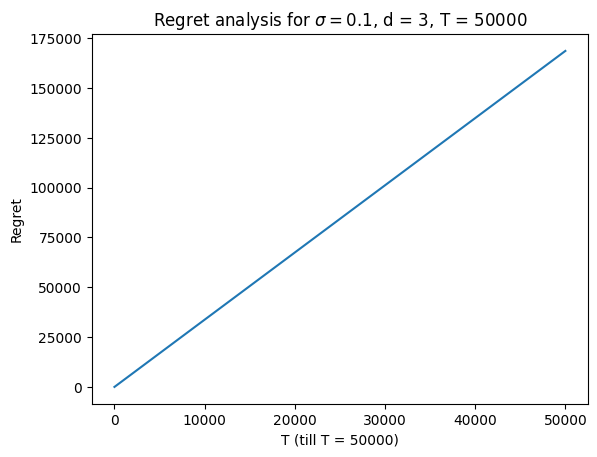

In [ ]:
plt.plot(range(0,T), regret)
plt.xlabel('T (till T = 50000)')
plt.ylabel('Regret')
plt.title('Regret analysis for ${\sigma} = 0.1$, d = 3, T = 50000')